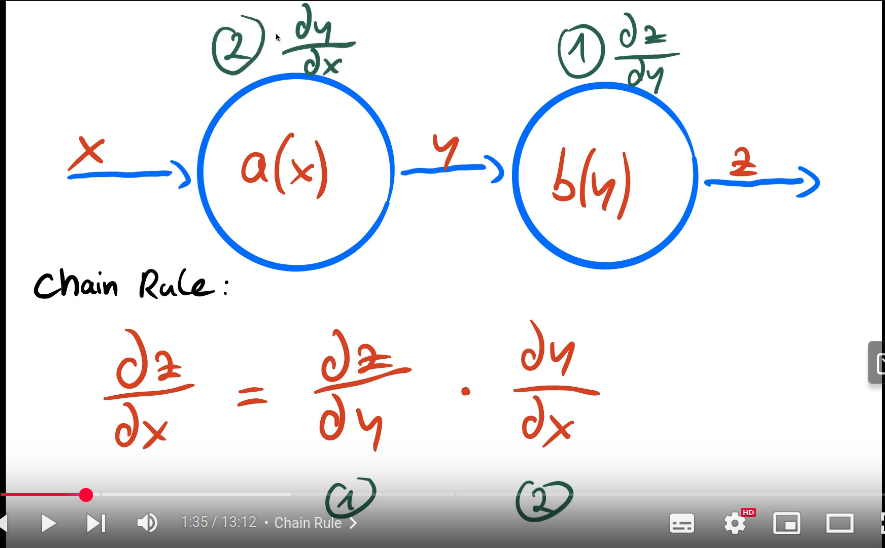

In [7]:
from IPython.display import Image
image_path = 'chain_rule.png'
Image(filename=image_path, width=400)

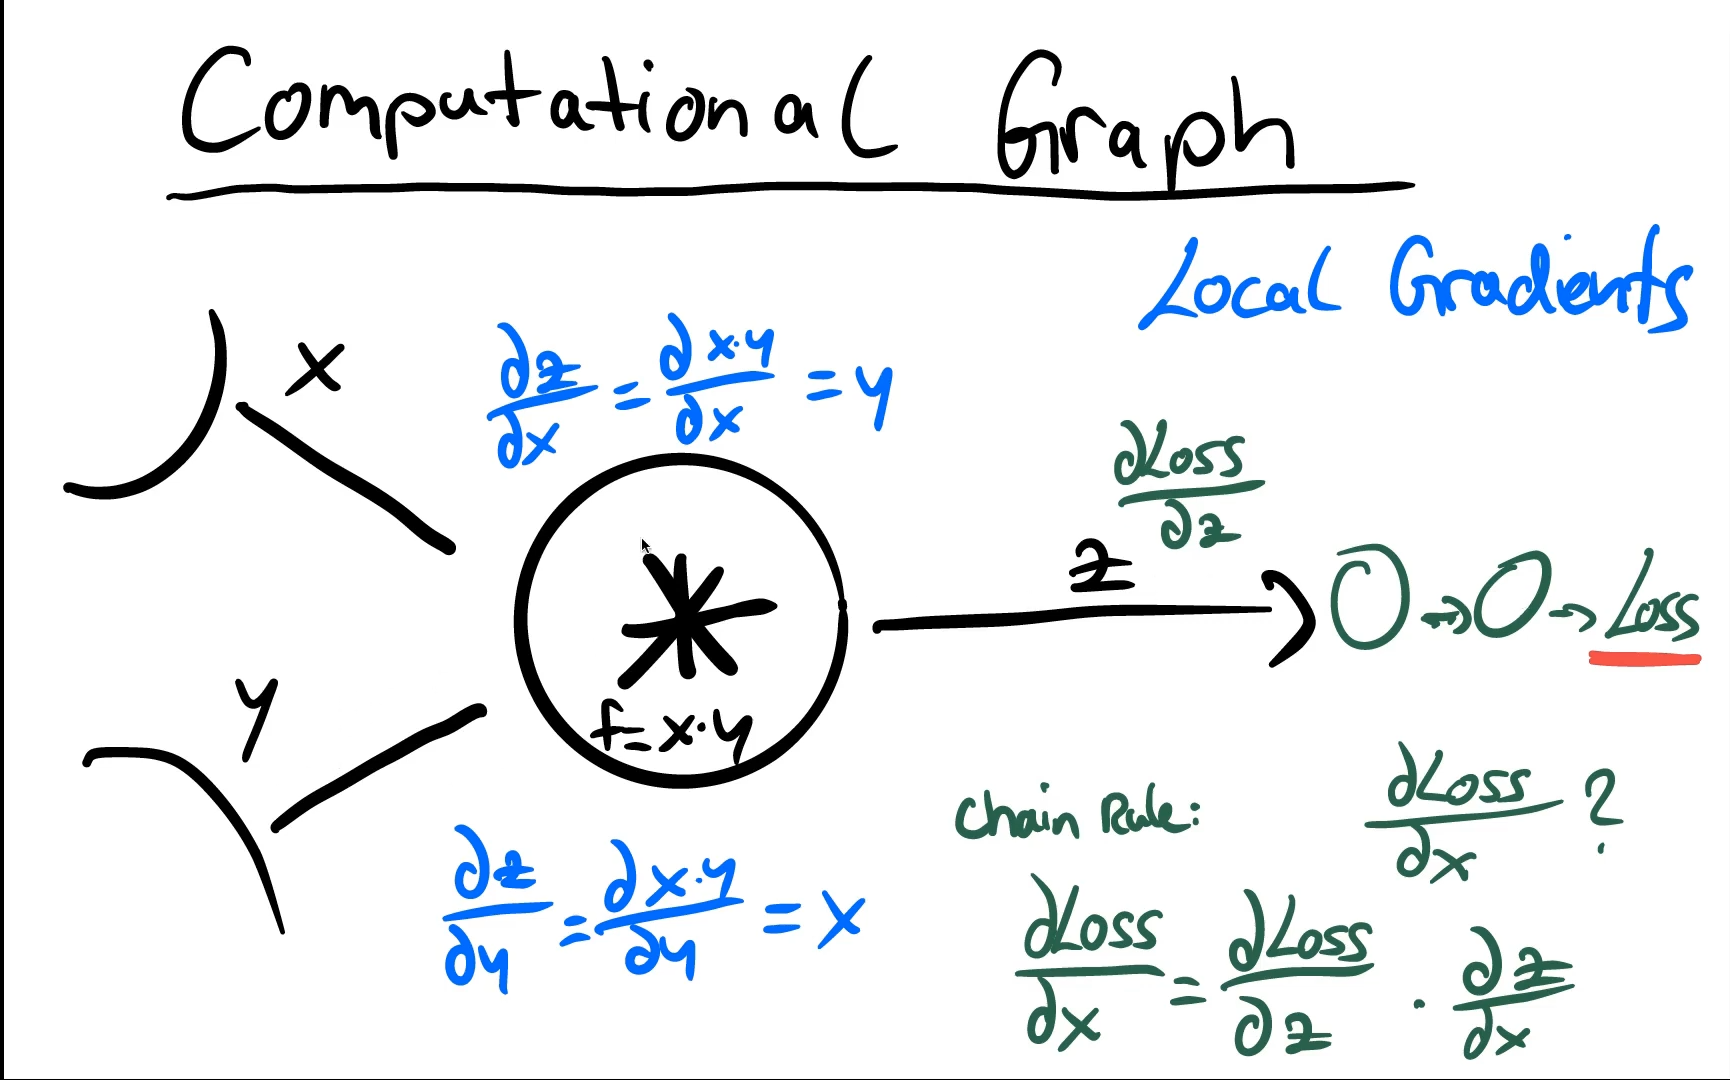

In [6]:
Image(filename='computational_graph.png', width=400)

- 1 Forward pass - Compute Loss
- Compute local gradients
- Backward pass - Compute dLoss/dWeights using the Chaing Rule

---
#### Chain Rule
- In calculus, if a function is built from other function, the dertivative 'chains' them
- if z=f(y), y=g(x)
- then dz/dx = dz/dy . dy/dx
- Forward pass - compute actual values (no chain rule needed)
- Backward pass - compute gradients (chain rule is crucial)
---

#### Forward pass (just computatoin, no chain rule)
- start with x=2
- compute y=x+3 = 5
- compute z=y^2 = 25
- Forward pass just executes the function step by step
---

#### Backward Pass (Chain rule for derivations)
- We want dz/dx
- Step 1 - dz/dy = 2y = 10
- Step 2 - dy/dx = 1
- Chain rule - dz/dx = dz/dy . dy/dx = 10.1 = 10
- Backward pass = propagating derivatives backward through the graph
--- 

Thats why pytorch stores the computation graph with grad_fn - so it knows how to apply the chain rule automativlly during .backward()
- The computation Graph - stores operation we applied, inputs were used, and how to compute the gradient for that operation. This 'memory' stored in computation graph
---

#### Example
- x = torch.tensor(2.0, require_grad=True)   # leaf node
- y = x + 3   # operation 1
- z = y*y     # operation 2
>
- x has no grad_fn -> its a leaf tensor your created 
- y has grad_fn=Addbackward> -> Pytorch remembers y = x+3 and knows how to differentate an addition.
- z has grad_fn=Mulbackward> -> Pytorch remembers z = y*y and know how to differentiate a multiplication.

*.backward()*
- z.backward()
> 
- Pytorch starts from z (the final scalar)
- Looks at z.grad_fn (MulBackward()).This object knows the derivative rule for multiplication.
- dz/dy = 2y
>
- Then it goes to y.grad_fn (AddBackward). This object knows
- dy/dx = 1
>
- Chain rule connects them
- dz/dx = dz/dy . dy/dx
- The gradient is stored in x.grad 

---

***Gradient***
- It tells the direction of the steepest ascent (where the error increases the most). By subtracting it, we move in the opposite direction to decrease the error.
>
***Learning Rate***
- It is (Small number like 0.01) controls the size of the step you take. Multiplying by the full gradient (like 10) would cause massive, unstable jump. The learning rate ensures we take a small, controlled step in the right direction.

In [4]:
import torch
x = torch.tensor(2.0, requires_grad=True)

y = x+3
z = y*y

print(f"x: {x}, y: {y}, z: {z}")
print(f"x.grad: {x.grad}")

print("y:", y) 
print("z:", z)
print("z.grad_fn:", z.grad_fn)  

z.backward()

print(f"x: {x}, y: {y}, z: {z}")
print(f"x.grad: {x.grad}")  # dz/dx

# The gradients wont calculated until we call backward()
# Before calling backward, x_grad is None, it only know the function (add, mul), inputs

x: 2.0, y: 5.0, z: 25.0
x.grad: None
y: tensor(5., grad_fn=<AddBackward0>)
z: tensor(25., grad_fn=<MulBackward0>)
z.grad_fn: <MulBackward0 object at 0x7c3be6f79f60>
x: 2.0, y: 5.0, z: 25.0
x.grad: 10.0


- require_grad = True -> An attribute u set on tensor that tells pytroch to track all opeartaions performed on it to prepare for gradient calculation.
>
- tensor.backward() -> A method called on a final output tensor (usually the loss). It automatically calculates the gradient of that tensor with respect to all tracked input tensors using the chain rule (backpropagation).
>
- tensor.grad -> An attribute of a tensor where the calculated gradient is stored after you call .backward(). we use this value to update weights
>
- optimizer.zero_grad() -> A method used to reset the .grad attribute of all model parameters to zero. You must casll this before .backward() in each training loop because pytorch accumulates gradients by default.
>
- torch.no_grad() -> A context manager that creates a block of code wheere gradient tracking is temporarily turned off. Its used for model evaluation to save memory and speed computation.

In [1]:
import numpy as np

# --- 1. Data and Network Architecture ---
# XOR problem data
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]]) # Inputs
y = np.array([[0], [1], [1], [0]])              # Outputs

# Define network dimensions
input_neurons = 2
hidden1_neurons = 5
hidden2_neurons = 5
output_neurons = 1

# --- 2. Initialize Weights and Biases Randomly ---
# These are the values we will train and adjust
W1 = np.random.uniform(size=(input_neurons, hidden1_neurons))
b1 = np.random.uniform(size=(1, hidden1_neurons))
W2 = np.random.uniform(size=(hidden1_neurons, hidden2_neurons))
b2 = np.random.uniform(size=(1, hidden2_neurons))
W3 = np.random.uniform(size=(hidden2_neurons, output_neurons))
b3 = np.random.uniform(size=(1, output_neurons))

# Activation function (Sigmoid) and its derivative
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)

# --- 3. Training the Network ---
learning_rate = 0.1
epochs = 20000

for i in range(epochs):
    # FORWARD PROPAGATION
    # Layer 1
    hidden1_input = np.dot(X, W1) + b1
    hidden1_output = sigmoid(hidden1_input)

    # Layer 2
    hidden2_input = np.dot(hidden1_output, W2) + b2
    hidden2_output = sigmoid(hidden2_input)

    # Output Layer
    output_layer_input = np.dot(hidden2_output, W3) + b3
    predicted_output = sigmoid(output_layer_input)

    # BACKPROPAGATION
    # Calculate error
    error = y - predicted_output

    # Calculate gradients (chain rule)
    d_predicted_output = error * sigmoid_derivative(predicted_output)
    
    error_hidden2 = d_predicted_output.dot(W3.T)
    d_hidden2 = error_hidden2 * sigmoid_derivative(hidden2_output)
    
    error_hidden1 = d_hidden2.dot(W2.T)
    d_hidden1 = error_hidden1 * sigmoid_derivative(hidden1_output)

    # UPDATE WEIGHTS AND BIASES
    W3 += hidden2_output.T.dot(d_predicted_output) * learning_rate
    b3 += np.sum(d_predicted_output, axis=0, keepdims=True) * learning_rate
    
    W2 += hidden1_output.T.dot(d_hidden2) * learning_rate
    b2 += np.sum(d_hidden2, axis=0, keepdims=True) * learning_rate
    
    W1 += X.T.dot(d_hidden1) * learning_rate
    b1 += np.sum(d_hidden1, axis=0, keepdims=True) * learning_rate

    # Print loss occasionally to see progress
    if i % 2000 == 0:
        loss = np.mean(np.square(error))
        print(f'Epoch {i}, Loss: {loss:.4f}')

# --- 4. Finalized Weights and Biases ---
print("\n--- Training Complete. Finalized Values: ---")
print("\n## Weights & Biases for Hidden Layer 1 (W1, b1):")
print("W1:\n", W1)
print("b1:\n", b1)
print("\n## Weights & Biases for Hidden Layer 2 (W2, b2):")
print("W2:\n", W2)
print("b2:\n", b2)
print("\n## Weights & Biases for Output Layer (W3, b3):")
print("W3:\n", W3)
print("b3:\n", b3)

# --- 5. Testing Process ---
print("\n--- Testing the Trained Network ---")
# Use the final weights/biases for a forward pass
hidden1_input_test = np.dot(X, W1) + b1
hidden1_output_test = sigmoid(hidden1_input_test)
hidden2_input_test = np.dot(hidden1_output_test, W2) + b2
hidden2_output_test = sigmoid(hidden2_input_test)
output_layer_input_test = np.dot(hidden2_output_test, W3) + b3
final_prediction = sigmoid(output_layer_input_test)

print("\nInput Data:\n", X)
print("\nFinal Predictions (Raw Output):\n", final_prediction)
print("\nFinal Predictions (Rounded to 0 or 1):\n", np.round(final_prediction))

Epoch 0, Loss: 0.4310
Epoch 2000, Loss: 0.2499
Epoch 4000, Loss: 0.2495
Epoch 6000, Loss: 0.2486
Epoch 8000, Loss: 0.2437
Epoch 10000, Loss: 0.1929
Epoch 12000, Loss: 0.1643
Epoch 14000, Loss: 0.0107
Epoch 16000, Loss: 0.0022
Epoch 18000, Loss: 0.0011

--- Training Complete. Finalized Values: ---

## Weights & Biases for Hidden Layer 1 (W1, b1):
W1:
 [[1.6521184  2.31250933 4.14175039 4.65451761 0.62580958]
 [0.71985906 2.35319637 4.00002066 4.52545121 1.70510876]]
b1:
 [[-1.24298339 -3.52515145 -1.09323729 -1.47582946 -1.1844131 ]]

## Weights & Biases for Hidden Layer 2 (W2, b2):
W2:
 [[ 0.38393663 -2.57440212 -0.11909052  1.93528231 -0.08781354]
 [ 0.34055976 -2.11669659  0.56292067  4.17888233  0.24974934]
 [ 0.5817139   3.34639824  0.21378258 -1.74688995  0.79668945]
 [ 0.68865398  3.89517443  0.23976848 -2.65013542  1.51895253]
 [ 0.54815048 -1.54001181  0.35595388  2.04365342  0.34808965]]
b2:
 [[ 0.90235029 -3.03891784  0.55222258 -0.25613651 -0.12651272]]

## Weights & Biases 